In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Wave_propogation

/content/drive/My Drive/Wave_propogation


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
import os
from moviepy.editor import ImageSequenceClip
import time
import torch
from PIL import Image
import torchvision.transforms as transforms

%load_ext autoreload
%autoreload 2

In [ ]:
!pip install GPUtil

In [ ]:
!python conv_gru.py

1 torch.Size([1, 10, 32, 6, 6])
torch.Size([1, 32, 6, 6])


In [ ]:
nx = 200 # number of grid points in the horizontal direction
nz = 200 # number of grid points in the vertical direction
dd = 5.0 # grid cell size
nt = 200 # number of time samples to be modeled
dt = 0.0005 # time step
srcx = 20 # source horizontal location in meters
srcz = 10 # source vertical location in meters

nabs = int( min(nx, nz) * 0.1 ) #40 # number of absorbing cells on the boundary
a = 0.0053 # strength of sponge layer
FreeSurf=False # free surface condition of top (False for now)

In [ ]:
class Simulation(object):
  def __init__(self, nx, nz, dd, nt, dt, srcx, srcz, 
               nabs, a, FreeSurf, vp, wav):
    self.nx = nx # number of grid points in the horizontal direction
    self.nz = nz # number of grid points in the vertical direction

    self.dd = dd # grid cell size
    self.nt = nt # number of time samples to be modeled
    self.dt = dt # time step

    self.srcx = srcx # source horizontal location in meters
    self.srcz = srcz # source vertical location in meters

    self.nabs = nabs # number of absorbing cells on the boundary
    self.a = a # strength of sponge layer
    self.FreeSurf = FreeSurf # free surface condition of top (False for now)

    self.vp = vp

    self.time = np.linspace(0, nt * dt, nt) # time vector

    self.wav = wav
    
    size = (self.vp.shape[0], self.vp.shape[1], self.wav.shape[0])
    self.field2d = np.zeros(size, dtype=np.float) # define variables  - field2d is output wavefield
    # self.set_source_matrixes()
    self.gen_absorb()

  def update_params(self):
    self.nabs = int(min(self.nx, self.nz) * 0.1)
    self.time = np.arange(0, nt*dt, dt) # time vector
    size = (self.vp.shape[0], self.vp.shape[1], self.wav.shape[0])
    self.field2d = np.zeros(size, dtype=np.float) # define variables  - field2d is output wavefield
    # self.set_source_matrixes()
    self.gen_absorb()


  def get_source(self, i):
    srci = int(self.srcx / self.dd) # find where source is located on the grid
    srcj = int(self.srcz/self.dd)
    return (srci, srcj, self.wav[i])


  
  def gen_absorb(self):
    absorb = np.ones((self.nx,self.nz))
    abs_coefs = np.zeros(self.nabs)
    abs_coefs = np.exp(-(self.a**2 * (self.nabs-np.arange(self.nabs))**2))
    absorb[:self.nabs,:] = absorb[:self.nabs,:]*np.expand_dims(abs_coefs,1)
    absorb[-self.nabs:,:] = absorb[-self.nabs:,:]*np.expand_dims(abs_coefs[::-1],1)
    absorb[:,-self.nabs:] = absorb[:,-self.nabs:]*abs_coefs[::-1]
    if(self.FreeSurf==False):
        absorb[:,:self.nabs] = absorb[:,:self.nabs]*abs_coefs
    self.absorb = absorb


  def comp_deriv(self, p):
    pdx2 = np.zeros(p.shape)
    pdz2 = np.zeros(p.shape)

    pdx2[1:-1,1:-1] = (p[2:,1:-1]-2*p[1:-1,1:-1]+p[:-2,1:-1])/(self.dd**2)
    pdz2[1:-1,1:-1] = (p[1:-1,2:]-2*p[1:-1,1:-1]+p[1:-1,:-2])/(self.dd**2)
    return pdx2, pdz2


  def fd_ac(self):
    srci = int(self.srcx / self.dd) # find where source is located on the grid
    srcj = int(self.srcz/self.dd)
    
    self.srci = srci
    self.srcj = srcj

    nx, nz = self.vp.shape # infer shapes
    #nt = self.nt #self.wav.shape[0]
 
    
    p = np.zeros((nx, nz), dtype=np.float) # these are pressures at current, prev and next steps
    ppast = np.zeros((nx, nz), dtype=np.float)
    pfut = np.zeros((nx, nz), dtype=np.float)
    
    vp2 = self.vp**2 # square of velocity for easier computation
    # absorb = self.gen_absorb # generate absorbing mask
    
    for i in range(nt): # main loop
        pdx2, pdz2 = self.comp_deriv(p) # compute pressure derivatives

        pfut = 2*p + vp2*dt**2 * (pdx2 + pdz2) - ppast # compute future pressure from current and prev 

        pfut[srci, srcj] = pfut[srci, srcj] + self.wav[i] / self.dd**2 * self.dt ** 2 # inject source term at selected point
        
        p *= self.absorb # apply absorbing mask
        pfut *= self.absorb # apply absorbing mask

        self.field2d[:, :, i] = p  # save current pressure in output array

        ppast = p # redefine arrays moving to next step
        p = pfut

  def get_input(self, i):
    dict_inp = {}
    dict_inp['source'] = self.get_source(i) # return index_x, index_z, wav[i]
    dict_inp['vp'] = self.vp #
    dict_inp['dd'] = self.dd
    dict_inp['dt'] = self.dt 
    dict_inp['absorb'] = self.absorb #
    dict_inp['p'] = self.field2d[:, :, i] #

    return dict_inp

In [ ]:
from scipy.ndimage import gaussian_filter
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

marm_size = 141
factor = 1.


imsize = (nx, nz)
loader = transforms.Compose([transforms.RandomCrop(int(marm_size * factor)),
                             transforms.Resize(imsize),  # scale imported image
                             transforms.ToTensor()])

def rgb2gray(rgb):

    r, g, b = rgb[0,:,:], rgb[1,:,:], rgb[2,:,:]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    
    image = loader(image)#.unsqueeze(0)
    # image = rgb2gray(image)#.unsqueeze(0).unsqueeze(0)

    return image#.to(device, torch.float)

def get_vp(path_img='./images_vp/'):
  list_img = os.listdir(path_img)
  #np.random.RandomState(0)
  indx = np.random.randint(low=0, high=len(list_img))
 
  img_tensor = image_loader(path_img+list_img[indx])
  img_tensor = rgb2gray(img_tensor)
  img_tensor = img_tensor.numpy()
  img_tensor -= img_tensor.min()
  img_tensor = img_tensor / img_tensor.max()

  #np.random.RandomState(0)
  low = np.random.randint(low=5, high=40)
  #np.random.RandomState(0)
  high = np.random.randint(low=low + 10, high=100)

  low *= 1e+2
  high *= 1e+2

  img_tensor = img_tensor * (high - low) + low
  img_tensor = np.clip(img_tensor, low, high)
  img_tensor = gaussian_filter(img_tensor, sigma=img_tensor.std()/100.)
  #img_tensor = np.ones_like(img_tensor) * low
  return img_tensor


In [ ]:
def plot_snapshots(snapshot_list, col_num: int = 3, figsize=(15, 10)):
  plt.figure(figsize=figsize)
  for i in range(len(snapshot_list)):
      plt.subplot(np.ceil(len(snapshot_list) / col_num), col_num, i + 1)
      plt.axis('off')
      plt.imshow(snapshot_list[i], cmap=plt.cm.BuPu, interpolation='nearest')

In [ ]:


# vp = np.arange(2000,4500,(4500-2000)/nz)
# vp = np.tile(np.expand_dims(vp,0),[nx,1]) # just coming up with a velocity model
vp = get_vp()
#vp = np.ones((nx,nz))*3000.0

time_vec = np.linspace(0, nt * dt, nt) # time vector
f0 = 15. # central frequency of the wavelet
t0 = 1/f0 # a shift to make sure wavelet is causal
scale = 1.1e+8
wav  = scale * (1.0-2.0*np.power(np.pi*f0*(time_vec-t0),2))*np.exp(-np.power(np.pi*f0*(time_vec-t0),2)) # computing the wavelet

Simulator = Simulation(nx, nz, dd, nt, dt, srcx, srcz, nabs, a, FreeSurf, vp, wav)

In [ ]:
start_seconds = time.time()
Simulator.fd_ac()
end_seconds = time.time()
print(end_seconds - start_seconds)

0.26610589027404785


In [ ]:
Simulator.field2d.max()

2.181632712665533

In [ ]:
s = Simulator.get_input(0)

In [ ]:


# tr = Simulator.get_input_and_label(0)
# tr['input'].shape
# tr['label'].shape

In [ ]:
def get_rand_a():
  sigma = np.random.choice(np.array([5, 10, 15, 20]))
  return 1/(2*sigma**2)

In [ ]:
class ParamsGenerator(object):
  def __init__(self, 
               simulator,
               N_min, N_max, 
               dd_min, dd_max, rs=0):
    
    self.rs = rs
    self.simulator = simulator

    self._set_min_max('N', N_min, N_max)
    self._set_min_max('vp', self.simulator.vp.min(), self.simulator.vp.max())
    self._set_min_max('dd', dd_min, dd_max)

    self._generate()

  def _set_min_max(self, name, var_min, var_max):
    setattr(self, name + '_min', var_min)
    setattr(self, name + '_max', var_max)

  def _generate(self):
    #np.random.RandomState(self.rs)
    self.N_lam = np.random.uniform(low=self.N_min, high=self.N_max)
    
    #np.random.RandomState(self.rs)
    self.dd = np.random.uniform(low=self.dd_min, high=self.dd_max)
    #f_max = min(256./self.dd, self.vp_min/self.dd/self.N_lam)
    f_max = self.vp_min/self.dd/self.N_lam
    #np.random.RandomState(self.rs)
    self.f0 = np.random.uniform(low=f_max*0.5, high=0.7*f_max)

    #np.random.RandomState(self.rs)
    self.dt = np.random.uniform(low=self.dd/self.vp_max/np.sqrt(2.)*0.2, 
                                high=self.dd/self.vp_max/np.sqrt(2.)*0.9)
    
    self.srcx = self._get_rand_src(self.dd, self.simulator.nx, self.simulator.nabs)
    self.srcz = self._get_rand_src(self.dd, self.simulator.nz, self.simulator.nabs)

  def set_simulator_params(self):
    self.simulator.dt = self.dt
    self.simulator.srcx = self.srcx
    self.simulator.srcz = self.srcz
    self.simulator.dd = self.dd

    self.simulator.wav = self.get_rand_wav(self.simulator.nt, self.simulator.dt, self.f0)
    self.simulator.update_params()

  def _get_rand_src(self, dd, n, nabs):
    #np.random.RandomState(self.rs)
    return np.random.uniform(low = (dd * n) * (nabs / n + 0.05), high = (dd * n) * (1 - nabs / n - 0.05))

  def get_rand_wav(self, nt, dt, f0):
    time_vec = np.linspace(0, nt * dt, nt) # time vector
    # f0 = np.random.choice(np.array([25, 30])) # central frequency of the wavelet
    t0 = 1./f0 # a shift to make sure wavelet is causal
    scale = 1.#1e+8
    wav  = scale * (1.0-2.0*np.power(np.pi*f0*(time_vec-t0),2))*np.exp(-np.power(np.pi*f0*(time_vec-t0),2)) # computing the wavelet
    return wav#, f0


In [ ]:
N_min = 3.
N_max = 10.
dd_min = 1.
dd_max = 30.

def get_batch(batchsize = 20):
  batch_sols = []
  batch_target = []
  initial_features = []
  
  b = 0
  while b < batchsize:
    Simulator.a = get_rand_a()
    Simulator.vp = get_vp()

    params_generator = ParamsGenerator(Simulator, N_min=N_min, N_max=N_max, dd_min=dd_min, dd_max=dd_max)
    params_generator.set_simulator_params()

    print('CFL: ', Simulator.dt * Simulator.vp.max() * np.sqrt(2.) / Simulator.dd)
    #N_lam = np.random.uniform(low=8.0, high=12.0)
    
    #Simulator.dd = get_rand_dd(Simulator.vp.min(), f0)
    
  
    #Simulator.dt = get_rand_dt(Simulator.dd, Simulator.vp.max())
    #Simulator.srcx = get_rand_src(Simulator.dd, Simulator.nx, Simulator.nabs)
    #Simulator.srcz = get_rand_src(Simulator.dd, Simulator.nz, Simulator.nabs)
    #Simulator.wav = get_rand_wav(Simulator.nt, Simulator.dt, f0)
    #Simulator.nt = 200
    # print(Simulator.wav.shape)
    #Simulator.update_params()
    
    # print(Simulator.nt)
    Simulator.fd_ac()
    # print(Simulator.field2d.shape)
    Simulator.field2d = Simulator.field2d.transpose((2, 0, 1))# * 1e+8
    if Simulator.field2d.max() < 1.:
      b += 1
      #print(Simulator.field2d.shape)
      batch_target.append(np.array(Simulator.field2d[1: ]))

      Simulator.field2d[:, Simulator.srci, Simulator.srcj] += Simulator.wav * Simulator.dt**2 / Simulator.dd**2
      batch_sols.append(np.array(Simulator.field2d[: -1]))
      #print(batch_sols[-1].shape)
      initial_features.append(np.array(np.stack((Simulator.vp,  Simulator.absorb))))

  return np.stack(batch_sols), np.stack(initial_features), np.stack(batch_target), Simulator.dd, f0

In [ ]:
def show_grig(img_batch, n_rows):
    batch_size = img_batch.shape[0]
    
    assert batch_size == n_rows ** 2
    
    plt.figure(figsize=(20, 20))
    for i in range(batch_size):
        plt.subplot(n_rows, n_rows, i + 1)
        plt.imshow(img_batch[i], cmap=plt.cm.BuPu, interpolation='nearest')
        plt.axis('off')
        plt.colorbar()
    plt.show()

In [ ]:
n_rows = 5
batch = get_batch(n_rows ** 2)

CFL:  0.8460352440924659
CFL:  0.3582604559511499
CFL:  0.7784522257268829
CFL:  0.38426017007205143
CFL:  0.5859597021376896
CFL:  0.7993795260452182
CFL:  0.7453785667944879
CFL:  0.853902710980747
CFL:  0.8985987507758468
CFL:  0.2142224327225875
CFL:  0.2891186658393304
CFL:  0.5286128415915834
CFL:  0.28676550788466165
CFL:  0.34306881823552693
CFL:  0.844024070716898
CFL:  0.8838679204881595
CFL:  0.30654433248492613
CFL:  0.8969567788575454
CFL:  0.4739600990150915
CFL:  0.3947011463428287
CFL:  0.5031866241498006
CFL:  0.794314042868755
CFL:  0.7035155880508376
CFL:  0.7173522949824719
CFL:  0.7153086068815755
CFL:  0.7499668443749884
CFL:  0.48895592015834594
CFL:  0.8907932396813729
CFL:  0.4966740168608565
CFL:  0.8223859714353258


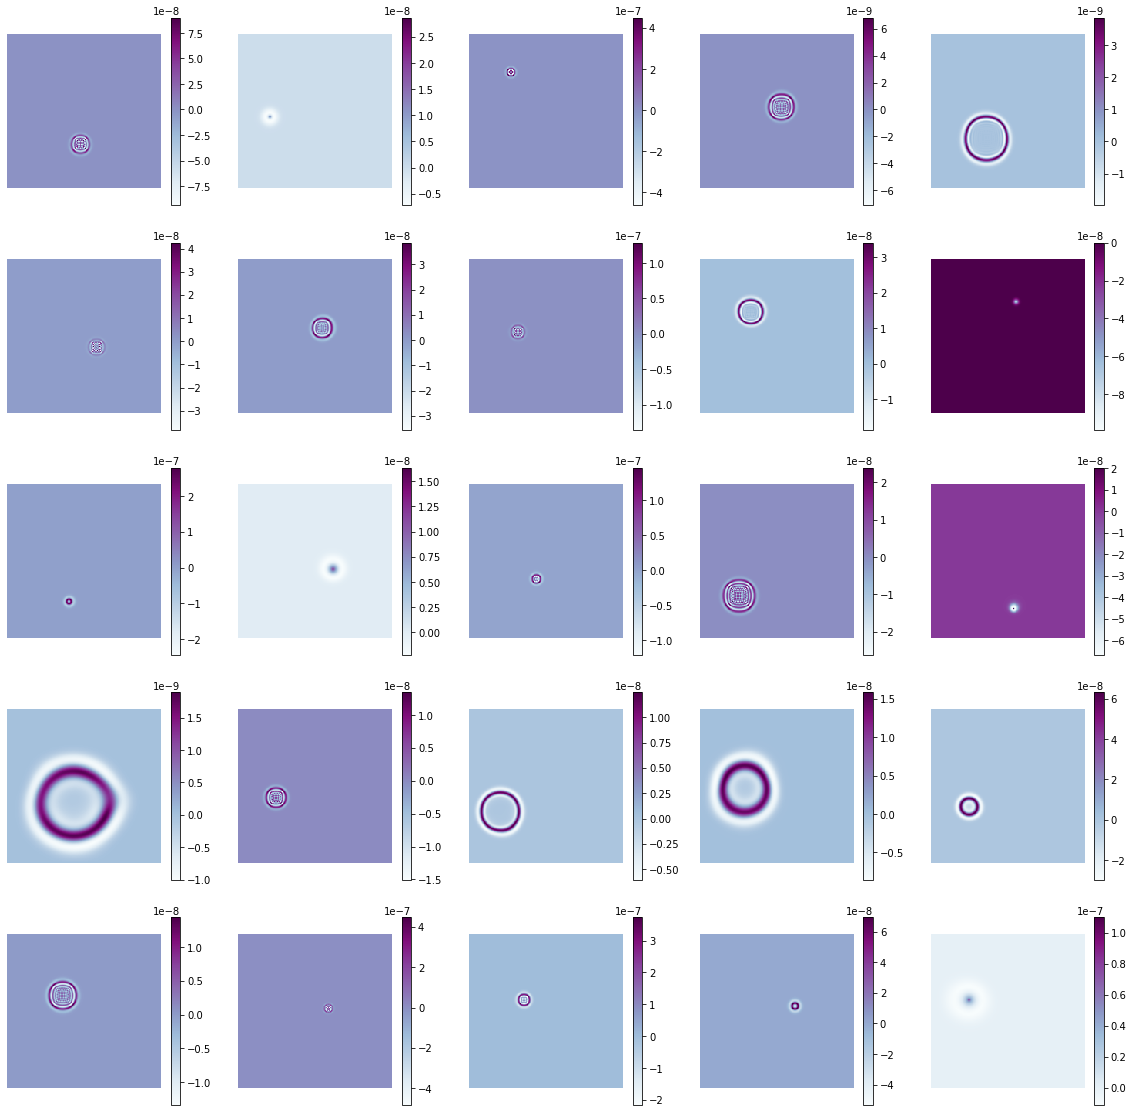

In [ ]:
show_grig(batch[0][:, 198, :, :], n_rows)

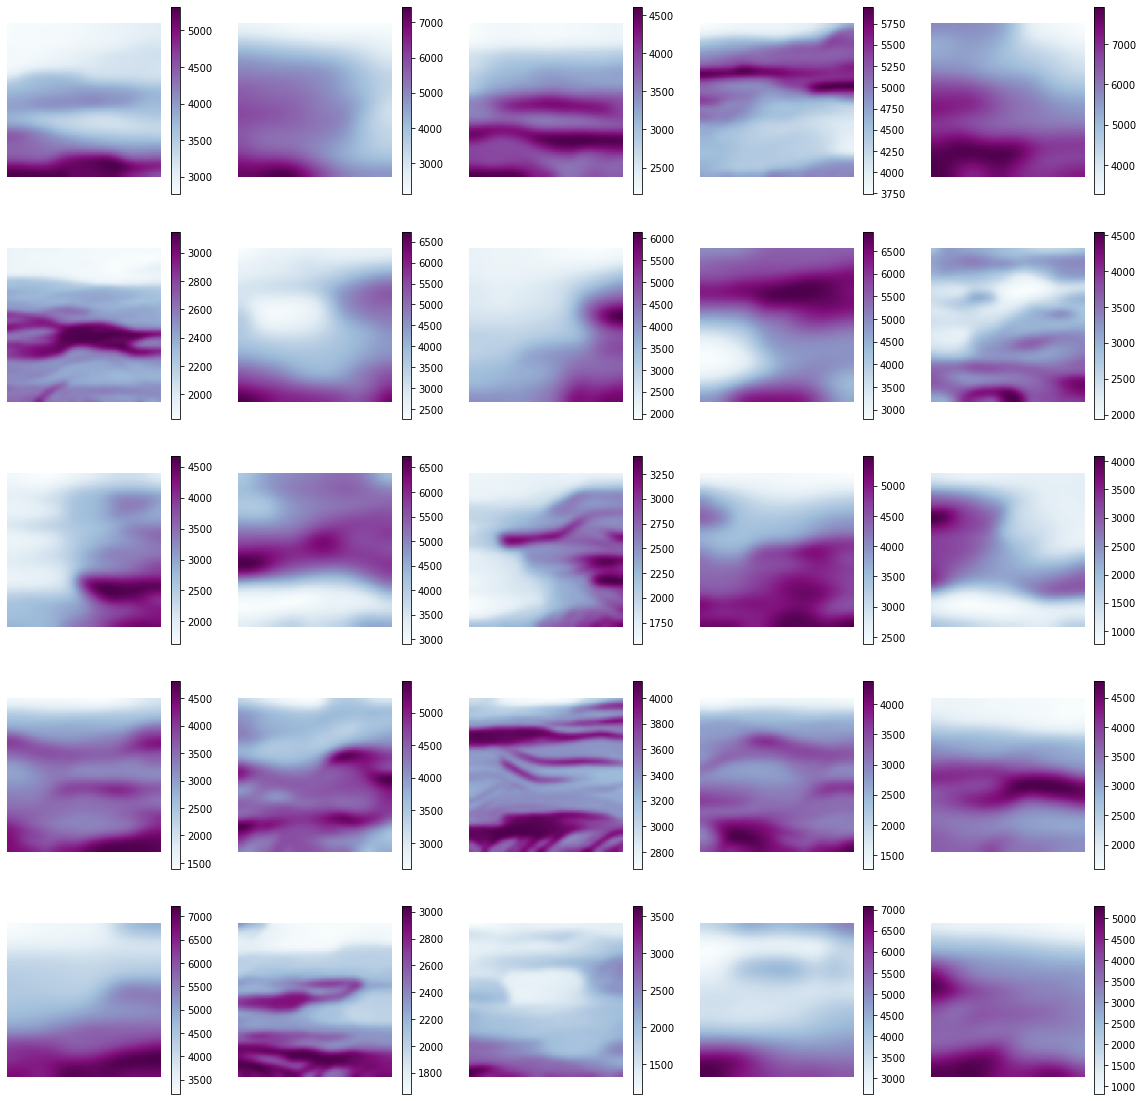

In [ ]:
show_grig(batch[1][:, 0, :, :], n_rows)

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [ ]:
from conv_gru import ConvGRU

class Encoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=32, kernel_size=3, activation=nn.Softplus):
    super(Encoder, self).__init__()
    
    self.model = nn.Sequential(nn.Conv2d(in_channels, out_channels // 2, kernel_size=kernel_size, padding=1), 
                                 nn.MaxPool2d(2), 
                                 activation(), 
                                 
                                 nn.BatchNorm2d(out_channels // 2),

                                 nn.Conv2d(out_channels // 2, out_channels, kernel_size=kernel_size, padding=1), 
                                 nn.MaxPool2d(2), 
                                 activation(),
                                 
                                 nn.BatchNorm2d(out_channels)
                                 )

  
  def forward(self, input):
    return self.model(input)

class Decoder(nn.Module):
  def __init__(self, in_channels=32, out_channels=1, kernel_size=3, activation=nn.Softplus):
    super(Decoder, self).__init__()
    
    self.model = nn.Sequential(nn.BatchNorm2d(in_channels),
                                
                               activation(), 
                               nn.Upsample(scale_factor=2, mode='bilinear'), 
                               nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=kernel_size, padding=1), 

                               nn.BatchNorm2d(in_channels // 2),

                               activation(), 
                               nn.Upsample(scale_factor=2, mode='bilinear'), 
                               nn.ConvTranspose2d(in_channels // 2, out_channels, kernel_size=kernel_size, padding=1),
                               )

  
  def forward(self, input):
    return self.model(input)


class WaveNet(nn.Module):
  def __init__(self, 
               bottle_neck=32, 
               rnn_channels=32,
               kernel_size=3,
               num_layers=1,
               activation=nn.Softplus):
    super(WaveNet, self).__init__()
    
    #self.data_to_h0 = Encoder(in_channels=2, out_channels=bottle_neck, 
    #                          kernel_size=kernel_size, activation=activation)
    self.encoder = Encoder(in_channels=1, out_channels=bottle_neck, 
                           kernel_size=kernel_size, activation=activation)

    self.decoder = Decoder(rnn_channels, out_channels=1, 
                           kernel_size=kernel_size, activation=activation)
    
    #self.conv_gru = ConvGRU(input_dim=bottle_neck,
    #                        hidden_dim=[rnn_channels],
    #                        kernel_size=(kernel_size, kernel_size),
    #                        num_layers=num_layers,
    #                        dtype=torch.DoubleTensor,
    #                        batch_first=True,
    #                        bias = True,
    #                        return_all_layers = False)

  
  def seq_to_cnn(self, data):
    shape = data.shape
    return data.reshape(shape[0] * shape[1], *shape[2:])

  
  def forward(self, solutions, eq_features):
    #print(eq_features.shape)
    #initial_hid = self.data_to_h0(eq_features)
    #print(initial_hid.shape)
    shape = solutions.shape

    x = self.encoder(self.seq_to_cnn(solutions.unsqueeze(2)))
    x = x.view(shape[0], shape[1], x.shape[1], x.shape[2], x.shape[3])
    #print(x.shape)
    #print(initial_hid.shape)

    #output, _ = self.conv_gru(x, initial_hid)
    #x = output[0]
    x = self.decoder(self.seq_to_cnn(x))
    
    #print(x.shape)
    
    return x.view(shape[0], shape[1], x.shape[1], x.shape[2], x.shape[3]).squeeze(2)


In [ ]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'cuda'

In [ ]:
import GPUtil


model = WaveNet(activation=nn.ReLU)
model.to(device)

#loss = nn.MSELoss()
loss = nn.L1Loss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-3)

GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% | 51% |


In [ ]:
batch_size = 2
n_epochs = 200
n_batches_per_epoch = 10
n_validation_batches = 5


Epoch: 51, train loss: 0.045765244774520396, val loss: 0.034964628517627716


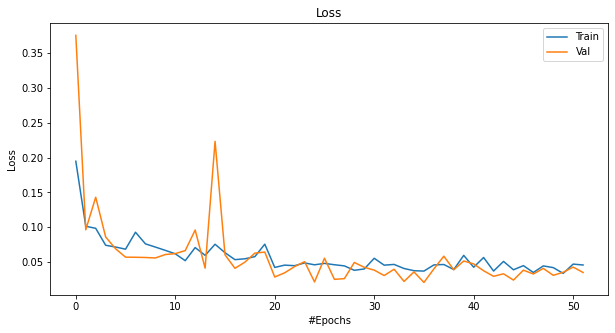

CFL:  0.5136869780354962
CFL:  0.8331339507134379
| ID | GPU | MEM |
------------------
|  0 |  3% |  7% |
| ID | GPU | MEM |
------------------
|  0 |  3% |  7% |
| ID | GPU | MEM |
------------------
|  0 |  3% |  7% |
| ID | GPU | MEM |
------------------
|  0 |  3% | 49% |
CFL:  0.34448811868974544
CFL:  0.4173752008088985


KeyboardInterrupt: ignored

In [ ]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import gc


loss_hist = {'train': [],
             'val': []}

for epoch in tqdm(range(n_epochs)):
    
    train_loss=0
    model.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        batch = get_batch(batch_size)
        optimizer.zero_grad()
        
        factor = batch[0].std()

        X = torch.tensor(batch[0]/factor, dtype=torch.float32).to(device)
        GPUtil.showUtilization()
        boundaries = torch.tensor(batch[1], dtype=torch.float32).to(device)
        GPUtil.showUtilization()
        Y = torch.tensor(batch[2]/factor, dtype=torch.float32).to(device)
        GPUtil.showUtilization()
        predictions = model(X, boundaries)
        loss_t = loss(predictions, Y)
        
        GPUtil.showUtilization()
        #print(loss_t)
        #print(predictions)
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.item()
        
        del X, Y, predictions
        gc.collect()
        torch.cuda.empty_cache()
        
    train_loss /= n_batches_per_epoch
    
    loss_hist['train'].append(train_loss)
    
    val_loss=0
    model.train(False)
    for _ in tqdm(range(n_validation_batches)):
        
        batch = get_batch(batch_size)
        #factor = abs(batch[0]).min()
        factor = batch[0].std()
        X = torch.tensor(batch[0]/factor, dtype=torch.float32).to(device)
        boundaries = torch.tensor(batch[1], dtype=torch.float32).to(device)
        Y = torch.tensor(batch[2]/factor, dtype=torch.float32).to(device)

        predictions = model(X, boundaries)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(batch[0][0, -1, :, :])
        plt.subplot(1, 2, 2)
        plt.imshow(batch[0][1, -1, :, :])
        plt.show()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(predictions[0, -1, :, :].cpu().data.numpy())
        plt.subplot(1, 2, 2)
        plt.imshow(predictions[1, -1, :, :].cpu().data.numpy())
        plt.show()
        
        val_loss += loss_t.item()

        del X, Y, predictions
        gc.collect()
        torch.cuda.empty_cache()
        
    val_loss /= n_validation_batches
    
    loss_hist['val'].append(val_loss)
    
    if epoch !=0:
      clear_output()
      print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))
      plt.figure(figsize=(10, 5))
      plt.plot(loss_hist['train'], label='Train')
      plt.plot(loss_hist['val'], label='Val')
      plt.xlabel('#Epochs')
      plt.ylabel('Loss')
      plt.title('Loss')
      plt.legend(loc='best')
      plt.show()

print("Finished!")

In [ ]:
for i in range(10):
  print(get_batch(1)[0].max())

0.09699004275653193
0.0028017354028249484
0.0
0.007794346650506785
0.0031739310891792166
0.015437629017600343
0.029208733199011558
0.0
0.0
0.015167622413150452


In [ ]:
import gc
del batch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
batch[0].max()

1.247313496499323e-07

In [ ]:
torch.save(model.state_dict(), './AE_maxpool_relu.pth')

NameError: ignored